# OpenVINO example with Squeezenet Model

This notebook illustrates how you can serve [OpenVINO](https://software.intel.com/en-us/openvino-toolkit) optimized models for Imagenet with Seldon Core.

<img src="car.png"/>

## Download Squeezenet Model

We will download a pre-trained and optimized model for OpenVINO CPU into a local folder.

In [1]:
!mkdir -p models/squeezenet/1 && \
    wget -O models/squeezenet/1/squeezenet1.1.xml https://s3-eu-west-1.amazonaws.com/seldon-public/openvino-squeeznet-model/squeezenet1.1.xml && \
    wget -O models/squeezenet/1/squeezenet1.1.mapping https://s3-eu-west-1.amazonaws.com/seldon-public/openvino-squeeznet-model/squeezenet1.1.mapping && \
    wget -O models/squeezenet/1/squeezenet1.1.bin https://s3-eu-west-1.amazonaws.com/seldon-public/openvino-squeeznet-model/squeezenet1.1.bin 

--2018-12-15 19:46:49--  https://s3-eu-west-1.amazonaws.com/seldon-public/openvino-squeeznet-model/squeezenet1.1.xml
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.49.60
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.49.60|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37345 (36K) [text/xml]
Saving to: ‘models/squeezenet/1/squeezenet1.1.xml’

models/squeezenet/1 100%[===================>]  36.47K  --.-KB/s    in 0.05s   

2018-12-15 19:46:50 (670 KB/s) - ‘models/squeezenet/1/squeezenet1.1.xml’ saved [37345/37345]

--2018-12-15 19:46:50--  https://s3-eu-west-1.amazonaws.com/seldon-public/openvino-squeeznet-model/squeezenet1.1.mapping
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.49.60
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.49.60|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9318 (9.1K) [binary/octet-stream]


## Run Seldon Core on Minikube

**The example below assumes Minikube 0.30.0 installed**

In [2]:
!minikube start --memory 4096 --disk-size 20g --extra-config=apiserver.authorization-mode=RBAC

Starting local Kubernetes v1.10.0 cluster...
Starting VM...
Getting VM IP address...
Moving files into cluster...
Setting up certs...
Connecting to cluster...
Setting up kubeconfig...
Starting cluster components...
Kubectl is now configured to use the cluster.
Loading cached images from config file.


In [2]:
!kubectl create namespace seldon

namespace/seldon created


In [3]:
!kubectl config set-context $(kubectl config current-context) --namespace=seldon

Context "minikube" modified.


In [4]:
!kubectl create clusterrolebinding kube-system-cluster-admin --clusterrole=cluster-admin --serviceaccount=kube-system:default

clusterrolebinding.rbac.authorization.k8s.io/kube-system-cluster-admin created


In [5]:
!helm init

$HELM_HOME has been configured at /home/clive/.helm.

Tiller (the Helm server-side component) has been installed into your Kubernetes Cluster.

Please note: by default, Tiller is deployed with an insecure 'allow unauthenticated users' policy.
To prevent this, run `helm init` with the --tiller-tls-verify flag.
For more information on securing your installation see: https://docs.helm.sh/using_helm/#securing-your-helm-installation
Happy Helming!


In [6]:
!kubectl rollout status deploy/tiller-deploy -n kube-system

Waiting for deployment "tiller-deploy" rollout to finish: 0 of 1 updated replicas are available...
deployment "tiller-deploy" successfully rolled out


In [7]:
!helm install ../../../helm-charts/seldon-core-crd --name seldon-core-crd  --set usage_metrics.enabled=true
!helm install ../../../helm-charts/seldon-core --name seldon-core --set ambassador.enabled=true

NAME:   seldon-core-crd
E1215 19:47:19.196165   18333 portforward.go:303] error copying from remote stream to local connection: readfrom tcp4 127.0.0.1:40989->127.0.0.1:37676: write tcp4 127.0.0.1:40989->127.0.0.1:37676: write: broken pipe
LAST DEPLOYED: Sat Dec 15 19:47:18 2018
NAMESPACE: seldon
STATUS: DEPLOYED

RESOURCES:
==> v1beta1/ClusterRoleBinding
NAME                        AGE
seldon-spartakus-volunteer  0s

==> v1/ConfigMap
NAME                     DATA  AGE
seldon-spartakus-config  3     1s

==> v1beta1/CustomResourceDefinition
NAME                                         AGE
seldondeployments.machinelearning.seldon.io  0s

==> v1beta1/Deployment
NAME                        DESIRED  CURRENT  UP-TO-DATE  AVAILABLE  AGE
seldon-spartakus-volunteer  1        0        0           0          0s

==> v1/ServiceAccount
NAME                        SECRETS  AGE
seldon-spartakus-volunteer  1        0s

==> v1beta1/ClusterRole
NAME                        AGE
seldon-spartakus-volunteer 

## Mount local folder onto minikube for HostPath
Run in the current folder:
```
minikube mount ./models:/opt/ml
```

This will allow the model folder containing the Squeezenet model to be accessed. For production deployments you would use a NFS volume.

## Build Combiner Image

In [9]:
!eval $(minikube docker-env) && cd resources/combiner && s2i build -E environment_grpc . seldonio/seldon-core-s2i-python36:0.4-SNAPSHOT seldonio/imagenet_combiner:0.1

---> Installing application source...
Build completed successfully


In [51]:
!eval $(minikube docker-env) && cd resources/transformer && s2i build -E environment_grpc . seldonio/seldon-core-s2i-python36:0.4-SNAPSHOT seldonio/imagenet_transformer:0.1

There is a newer version of minikube available (v0.31.0).  Download it here:
https://github.com/kubernetes/minikube/releases/tag/v0.31.0

To disable this notification, run the following:
minikube config set WantUpdateNotification false
---> Installing application source...
---> Installing dependencies ...
Running setup.py bdist_wheel for pyyaml: started
Running setup.py bdist_wheel for pyyaml: finished with status 'done'
Stored in directory: /root/.cache/pip/wheels/ad/da/0c/74eb680767247273e2cf2723482cb9c924fe70af57c334513f
Successfully built pyyaml
You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Build completed successfully


## Deploy Seldon Intel OpenVINO Graph

In [45]:
sys.path.append("../../../notebooks")
from visualizer import *

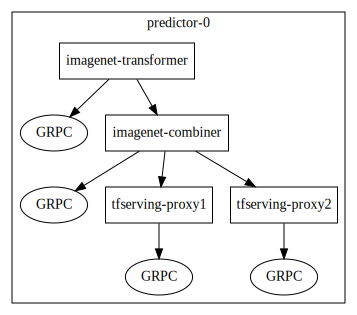

In [52]:
get_graph("seldon_openvino_ensemble.json")

In [10]:
!pygmentize seldon_openvino_ensemble.json

---
# Source: seldon-openvino/templates/hostPath.json

{
    "kind": "PersistentVolume",
    "apiVersion": "v1",
    "metadata": {
        "name": "hostpath-pvc"
    },
    "spec": {
        "capacity": {
            "storage": "1Gi"
        },
        "hostPath": {
            "path": "/opt/ml",
            "type": ""
        },
        "accessModes": [
            "ReadWriteOnce"
        ],
        "persistentVolumeReclaimPolicy": "Retain",
        "storageClassName": "manual"
    }
}

---
# Source: seldon-openvino/templates/openvino_deployment.json
{
    "apiVersion": "machinelearning.seldon.io/v1alpha2",
    "kind": "SeldonDeployment",
    "metadata": {
        "labels": {
            "app": "seldon"
        },
        "name": "openvino-model",
	"namespace": "seldon"	
    },
    "spec": {
        "name": "openvino",
        "predictors": [
            {
                "componentSpecs": [{
                    "spec": {
                        "containers": [
                       

In [11]:
!kubectl apply -f seldon_openvino_ensemble.json

persistentvolume/hostpath-pvc created
error: error parsing seldon_openvino_ensemble.json: error converting YAML to JSON: yaml: line 117: did not find expected ',' or '}'


# Serve Requests

**Ensure you port forward ambassador:**

```
kubectl port-forward $(kubectl get pods -n seldon -l service=ambassador -o jsonpath='{.items[0].metadata.name}') -n seldon 8003:8080
```

In [19]:
import tensorflow as tf
def grpc_request_ambassador(deploymentName,namespace,endpoint="localhost:8004",data=None):
    datadef = prediction_pb2.DefaultData(
                names = 'x',
                tftensor = tf.make_tensor_proto(data)
            )
    request = prediction_pb2.SeldonMessage(data = datadef)
    channel = grpc.insecure_channel(endpoint)
    stub = prediction_pb2_grpc.SeldonStub(channel)
    if namespace is None:
        metadata = [('seldon',deploymentName)]
    else:
        metadata = [('seldon',deploymentName),('namespace',namespace)]
    response = stub.Predict(request=request,metadata=metadata)
    return response


In [50]:
img = image.load_img("car.png", target_size=(227, 227))
x = image.img_to_array(img)
type(x)
print(x.dtype)

float32


In [55]:
%matplotlib inline
import numpy as np
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.preprocessing import image
import sys
import json
import matplotlib.pyplot as plt
import datetime
API_AMBASSADOR="localhost:8003"

def getImage(path):
    img = image.load_img(path, target_size=(227, 227))
    x = image.img_to_array(img)
    plt.imshow(x/255.)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

def getImageRaw(path):
    img = image.load_img(path, target_size=(227, 227))
    x = image.img_to_array(img)
    return x

#X = getImage("car.png")
#X = X.transpose((0,3,1,2))

X = getImageRaw("car.png")
print(X.shape)
start_time = datetime.datetime.now()
response = grpc_request_ambassador("openvino-model","seldon",API_AMBASSADOR,data=X)
end_time = datetime.datetime.now()
duration = (end_time - start_time).total_seconds() * 1000
print(duration)

result = tf.make_ndarray(response.data.tftensor)   
result = result.reshape(1,1000)

with open('imagenet_classes.json') as f:
    cnames = eval(f.read())

    for i in range(result.shape[0]):
        single_result = result[[i],...]
        ma = np.argmax(single_result)
        print("\t",i, cnames[ma])


(227, 227, 3)
100.90599999999999
	 0 sports car, sport car


In [59]:
durations = []
for i in range(500):
    start_time = datetime.datetime.now()
    response = grpc_request_ambassador("openvino-model","seldon",API_AMBASSADOR,data=X)
    end_time = datetime.datetime.now()
    duration = (end_time - start_time).total_seconds() * 1000
    durations.append(duration)
print(sum(durations) / float(len(durations)))

111.88285600000013
